

# Basketabll Activity Recognition using LOSO and LSTM Neural Network

# Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import glob

import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score,confusion_matrix, plot_confusion_matrix
import time
from typing import Any
import torch
import torch.nn as nn

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from pandas import DataFrame
from keras.models import load_model

files = glob.glob('/data/shk/dl-for-har/tutorial_notebooks/Prof_New/*.csv')

name = [file.split('/')[-1] for file in files]
df = pd.concat(map(pd.read_csv,files),ignore_index = True) #4230213 rows × 10 columns

data = df

#Considering only basketball
clean_data = data[data['basketball']!='not_labeled']
clean_data = clean_data[data['basketball'].notna()]
clean_data['basketball'].replace({'jumping':'layup'},inplace=True) #Replacing jumping by layup

new_data = clean_data[clean_data.coarse != 'game'] #623758 rows × 10 columns
new_data = new_data.drop(columns='coarse')
new_data = new_data.iloc[:,:6]
print('new_data',new_data.shape)
print('____')

# Sepearting Game data from train data
game_data = clean_data[clean_data.coarse == 'game']
game_data = game_data.drop(columns='coarse')
game_data = game_data.iloc[:,:6] #45446 rows × 6 columns
print('game_data',game_data.shape)

2022-08-15 08:48:20.160919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 08:48:20.160941: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


new_data (613454, 6)
____
game_data (45111, 6)


# Labelling the data

In [2]:
label = new_data['basketball']
x_axis = sorted(label.unique())
y_axis = label.value_counts()

X = new_data.iloc[:,:-1]#.astype(np.float32)

class_names = ['dribbling','shot','pass','layup','rebound']
num_classes = len(class_names)

def labelling(clean_data,data_y):
    clean_data[data_y == 'dribbling'] = 0
    clean_data[data_y == 'shot'] = 1
    clean_data[data_y == 'pass'] = 2
    clean_data[data_y == 'layup'] = 3
    clean_data[data_y == 'rebound'] = 4
    
    return data_y

y = labelling(new_data,new_data.iloc[:,-1]).astype(int)

subject = X['subject']
uni_subject = subject.unique()
uni_subject_count = subject.value_counts()

data_labelled = np.concatenate((X, y[:,None]), axis=1)[:,1:] #669204, 6


/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Special Preprocessing

In [3]:
data_bribbling = data_labelled[data_labelled[:,-1] == 0]
data_shot = data_labelled[data_labelled[:,-1] == 1]
data_pass = data_labelled[data_labelled[:,-1] == 2]
data_layup = data_labelled[data_labelled[:,-1] == 3]
data_rebound = data_labelled[data_labelled[:,-1] == 4]


def spilt(data):

    dd = np.asarray(data)
    T = int(0.8* len(dd))
    train_size = int(T)
    test_size = len(dd) - train_size

    train_df,test_df = torch.utils.data.random_split(dd, [train_size,test_size])
    X = train_df[:][:,0:4]
    Y = train_df[:][:,4]

    X_v = test_df[:][:,0:4]
    y_v = test_df[:][:,4]
  
    return X,Y,X_v,y_v

X_dribble,Y_dribble,X_v_dribble,y_v_dribble = spilt(data_bribbling)
X_shot,Y_shot,X_v_shot,y_v_shot = spilt(data_shot)
X_pass,Y_pass,X_v_pass,y_v_pass = spilt(data_pass)
X_layup,Y_layup,X_v_layup,y_v_layup = spilt(data_layup)
X_rebound,Y_rebound,X_v_rebound,y_v_rebound = spilt(data_rebound)

X = np.concatenate((X_dribble, X_shot,X_pass,X_layup,X_rebound), axis=0)
Y = np.concatenate((Y_dribble, Y_shot,Y_pass,Y_layup,Y_rebound), axis=0)

X_v = np.concatenate((X_v_dribble, X_v_shot,X_v_pass,X_v_layup,X_v_rebound), axis=0)
y_v = np.concatenate((y_v_dribble, y_v_shot,y_v_pass,y_v_layup,y_v_rebound), axis=0)

train_data = np.column_stack((X,Y))
valid_data = np.column_stack((X_v,y_v))

# Sliding Window

In [4]:
def sliding_window(data, samples_per_window, overlap_ratio):
    windows = []
    indices = []
    curr = 0
    win_len = int(samples_per_window)
    
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * (win_len))
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        windows.append(data[curr:curr + win_len])
        indices.append([curr, curr + win_len])
        curr = curr + win_len - overlapping_elements
    try:
        result_windows = np.array(windows)
        result_indices = np.array(indices)
    except:
        result_windows = np.empty(shape=(len(windows), win_len, data.shape[1]), dtype=object)
        result_indices = np.array(indices)
        for i in range(0, len(windows)):
            result_windows[i] = windows[i]
            result_indices[i] = indices[i]
    return result_windows, result_indices

def apply_sliding_window(data_x, data_y, sliding_window_size, sampling_rate, sliding_window_overlap):
    
    output_x, _ = sliding_window(data_x, sliding_window_size, sliding_window_overlap)
    output_y, _ = sliding_window(data_y, sliding_window_size, sliding_window_overlap)

    return output_x,output_y

sw_length = 50
sw_overlap = 25


train_valid_data = np.concatenate((train_data, valid_data), axis=0)
print('____Input to the LSTM____')
print(train_valid_data.shape)

____Input to the LSTM____
(613454, 5)


# Network

In [5]:
uni_subject

array(['e90f', '9bd4', 'ac59', 846, '4d70', '2dd9', 'a0da', 4991, '10f0',
       'b512', '05d8', 'ce9d', 'f2ad'], dtype=object)

In [10]:
def Network(uni_subject,train_valid_data):

    train_preds = []
    train_gt = []
    test_preds = []
    test_gt = []   

    loss_acc = []
    c_matrix = []
    f1_sub_train = []
    f1_sub_test = []
    sub_plot=[]

    for i,sbj in enumerate(uni_subject):
        print('\n name {2} VALIDATING FOR SUBJECT {0} OF {1}'.format(i+1, len(uni_subject),sbj))
        
        train_data_ = train_valid_data[train_valid_data[:, 0] != sbj]
        valid_data_ = train_valid_data[train_valid_data[:, 0] == sbj]


        X_train, y_train = apply_sliding_window(train_data_[:, :-1], train_data_[:, -1], sliding_window_size=sw_length, 
                                                sampling_rate=50, sliding_window_overlap=sw_overlap)


        X_valid, y_valid = apply_sliding_window(valid_data_[:, :-1], valid_data_[:, -1], sliding_window_size=sw_length, 
                                                sampling_rate=50, sliding_window_overlap=sw_overlap)


        X_train, X_valid = X_train[:, :, 1:], X_valid[:, :, 1:]
        y_train, y_valid = y_train[:,0], y_valid[:,0]

        X_train, y_train = X_train.astype(np.float32), y_train.astype(np.uint8)#(21413, 50, 3)
        X_valid, y_valid = X_valid.astype(np.float32), y_valid.astype(np.uint8)#(5352, 50, 3)

        #Model architecture            
        model = Sequential()
        model.add(LSTM(units=26,input_shape=[X_train.shape[1], X_train.shape[2]], activation = 'relu', return_sequences = True))
        model.add(Dropout(rate=0.1))
        model.add(Flatten())
        model.add(Dense(units=1000, activation='relu'))
        model.add(Dropout(rate=0.2))
        model.add(Dense(units=850, activation='relu'))
        model.add(Dropout(rate=0.3))
        model.add(Dense(units=5, activation='softmax'))

        #Compile the model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        hs = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),verbose=1) #, 
        y_pred_train = np.argmax(model.predict(X_train), axis=-1)
        y_pred_test = np.argmax(model.predict(X_valid), axis=-1)

        #Training
        acc_train = jaccard_score(y_train, y_pred_train, average='macro')
        pre_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
        reca_train = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
        f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

        train_preds = np.concatenate((np.array(train_preds, int), np.array(y_pred_train, int)))
        train_gt = np.concatenate((np.array(train_gt, int), np.array(y_train, int)))

        print("___Training____")
        print(f"accuracy {round(acc_train,3)*100} ,precision {round(pre_train,3)*100}, recall {round(reca_train,3)*100},f1_score {round(f1_train,3)*100} ")

        #Validation
        acc_test = jaccard_score(y_valid, y_pred_test, average='macro')
        pre_test = precision_score(y_valid, y_pred_test, average='macro', zero_division=0)
        reca_test = recall_score(y_valid, y_pred_test, average='macro', zero_division=0)
        f1_test = f1_score(y_valid, y_pred_test, average='macro', zero_division=0)

        test_preds = np.concatenate((np.array(test_preds, int), np.array(y_pred_test, int)))
        test_gt = np.concatenate((np.array(test_gt, int), np.array(y_valid, int)))

        print("___Validation____")
        print('\nVALIDATION RESULTS FOR SUBJECT {0}: '.format(i+1))
        print(f"accuracy {round(acc_test,3)*100} ,precision {round(pre_test,3)*100}, recall {round(reca_test,3)*100}, f1_score {round(f1_test,3)*100} ")

        #Graphs
        loss_acc.append(model.evaluate(X_valid,y_valid))
        c_matrix.append(confusion_matrix(y_valid, y_pred_test))
        f1_sub_train.append(f1_train)
        f1_sub_test.append(f1_test)
        sub_plot.append(hs.history)

            #Save Weights
        model.save_weights('./Pre_Trained_models/LOSO/LOSO',overwrite=True)
        model.save('./Pre_Trained_models/LOSO',overwrite=True)
        
    return train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,f1_sub_train,f1_sub_test,sub_plot

In [11]:
train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,f1_sub_train,f1_sub_test,sub_plot = Network(uni_subject,train_valid_data)


 name e90f VALIDATING FOR SUBJECT 1 OF 13
Epoch 1/30
463/463 [==============================] - 8s 16ms/step - loss: 0.4616 - accuracy: 0.8507 - val_loss: 0.3821 - val_accuracy: 0.8678
Epoch 2/30
463/463 [==============================] - 7s 16ms/step - loss: 0.2981 - accuracy: 0.8993 - val_loss: 0.3358 - val_accuracy: 0.8753
Epoch 3/30
463/463 [==============================] - 7s 16ms/step - loss: 0.2399 - accuracy: 0.9169 - val_loss: 0.3020 - val_accuracy: 0.8948
Epoch 4/30
463/463 [==============================] - 7s 16ms/step - loss: 0.2140 - accuracy: 0.9250 - val_loss: 0.2583 - val_accuracy: 0.9121
Epoch 5/30
463/463 [==============================] - 7s 16ms/step - loss: 0.1959 - accuracy: 0.9303 - val_loss: 0.2821 - val_accuracy: 0.9076
Epoch 6/30
463/463 [==============================] - 7s 16ms/step - loss: 0.1734 - accuracy: 0.9379 - val_loss: 0.2408 - val_accuracy: 0.9136
Epoch 7/30
463/463 [==============================] - 7s 16ms/step - loss: 0.1645 - accuracy: 0.939

INFO:tensorflow:Assets written to: ./LOSO/assets



 name 9bd4 VALIDATING FOR SUBJECT 2 OF 13
Epoch 1/30
468/468 [==============================] - 8s 16ms/step - loss: 0.4820 - accuracy: 0.8417 - val_loss: 1.7186 - val_accuracy: 0.1795
Epoch 2/30
468/468 [==============================] - 7s 16ms/step - loss: 0.3111 - accuracy: 0.8923 - val_loss: 3.3207 - val_accuracy: 0.2222
Epoch 3/30
468/468 [==============================] - 7s 16ms/step - loss: 0.2565 - accuracy: 0.9106 - val_loss: 1.9878 - val_accuracy: 0.2547
Epoch 4/30
468/468 [==============================] - 7s 16ms/step - loss: 0.2196 - accuracy: 0.9215 - val_loss: 3.3087 - val_accuracy: 0.2479
Epoch 5/30
468/468 [==============================] - 7s 15ms/step - loss: 0.1970 - accuracy: 0.9298 - val_loss: 1.3827 - val_accuracy: 0.4487
Epoch 6/30
468/468 [==============================] - 7s 15ms/step - loss: 0.1760 - accuracy: 0.9359 - val_loss: 1.1908 - val_accuracy: 0.6744
Epoch 7/30
468/468 [==============================] - 7s 15ms/step - loss: 0.1650 - accuracy: 0.940

INFO:tensorflow:Assets written to: ./LOSO/assets



 name ac59 VALIDATING FOR SUBJECT 3 OF 13
Epoch 1/30
466/466 [==============================] - 8s 16ms/step - loss: 0.4471 - accuracy: 0.8539 - val_loss: 0.7687 - val_accuracy: 0.7706
Epoch 2/30
466/466 [==============================] - 7s 16ms/step - loss: 0.2548 - accuracy: 0.9122 - val_loss: 1.2882 - val_accuracy: 0.7375
Epoch 3/30
466/466 [==============================] - 7s 16ms/step - loss: 0.2025 - accuracy: 0.9291 - val_loss: 1.0881 - val_accuracy: 0.7415
Epoch 4/30
466/466 [==============================] - 7s 16ms/step - loss: 0.1852 - accuracy: 0.9355 - val_loss: 1.1393 - val_accuracy: 0.7431
Epoch 5/30
466/466 [==============================] - 7s 16ms/step - loss: 0.1669 - accuracy: 0.9430 - val_loss: 1.4977 - val_accuracy: 0.6858
Epoch 6/30
466/466 [==============================] - 7s 15ms/step - loss: 0.1565 - accuracy: 0.9435 - val_loss: 1.3018 - val_accuracy: 0.7213
Epoch 7/30
466/466 [==============================] - 7s 16ms/step - loss: 0.1486 - accuracy: 0.947

INFO:tensorflow:Assets written to: ./LOSO/assets



 name 846 VALIDATING FOR SUBJECT 4 OF 13
Epoch 1/30
468/468 [==============================] - 8s 16ms/step - loss: 0.4885 - accuracy: 0.8422 - val_loss: 0.2968 - val_accuracy: 0.9174
Epoch 2/30
468/468 [==============================] - 7s 15ms/step - loss: 0.2790 - accuracy: 0.9048 - val_loss: 0.4651 - val_accuracy: 0.8585
Epoch 3/30
468/468 [==============================] - 7s 15ms/step - loss: 0.2319 - accuracy: 0.9180 - val_loss: 0.4322 - val_accuracy: 0.8576
Epoch 4/30
468/468 [==============================] - 7s 15ms/step - loss: 0.2051 - accuracy: 0.9258 - val_loss: 0.2591 - val_accuracy: 0.9174
Epoch 5/30
468/468 [==============================] - 7s 16ms/step - loss: 0.1859 - accuracy: 0.9339 - val_loss: 0.4016 - val_accuracy: 0.8711
Epoch 6/30
468/468 [==============================] - 7s 16ms/step - loss: 0.1717 - accuracy: 0.9420 - val_loss: 0.3062 - val_accuracy: 0.9115
Epoch 7/30
468/468 [==============================] - 7s 16ms/step - loss: 0.1560 - accuracy: 0.9444

INFO:tensorflow:Assets written to: ./LOSO/assets



 name 4d70 VALIDATING FOR SUBJECT 5 OF 13
Epoch 1/30
462/462 [==============================] - 8s 16ms/step - loss: 0.4451 - accuracy: 0.8532 - val_loss: 1.0671 - val_accuracy: 0.7749
Epoch 2/30
462/462 [==============================] - 7s 16ms/step - loss: 0.2631 - accuracy: 0.9067 - val_loss: 1.4278 - val_accuracy: 0.6993
Epoch 3/30
462/462 [==============================] - 7s 16ms/step - loss: 0.2147 - accuracy: 0.9225 - val_loss: 1.0270 - val_accuracy: 0.6609
Epoch 4/30
462/462 [==============================] - 7s 16ms/step - loss: 0.1983 - accuracy: 0.9281 - val_loss: 0.8342 - val_accuracy: 0.7625
Epoch 5/30
462/462 [==============================] - 7s 16ms/step - loss: 0.1762 - accuracy: 0.9361 - val_loss: 1.0278 - val_accuracy: 0.7654
Epoch 6/30
462/462 [==============================] - 7s 16ms/step - loss: 0.1601 - accuracy: 0.9434 - val_loss: 0.6831 - val_accuracy: 0.8017
Epoch 7/30
462/462 [==============================] - 7s 16ms/step - loss: 0.1487 - accuracy: 0.946

INFO:tensorflow:Assets written to: ./LOSO/assets



 name 2dd9 VALIDATING FOR SUBJECT 6 OF 13
Epoch 1/30
464/464 [==============================] - 8s 16ms/step - loss: 0.4536 - accuracy: 0.8553 - val_loss: 0.8638 - val_accuracy: 0.7315
Epoch 2/30
464/464 [==============================] - 7s 16ms/step - loss: 0.2690 - accuracy: 0.9057 - val_loss: 0.5565 - val_accuracy: 0.8510
Epoch 3/30
464/464 [==============================] - 7s 16ms/step - loss: 0.2230 - accuracy: 0.9220 - val_loss: 0.6503 - val_accuracy: 0.8351
Epoch 4/30
464/464 [==============================] - 7s 16ms/step - loss: 0.1906 - accuracy: 0.9323 - val_loss: 0.5578 - val_accuracy: 0.8457
Epoch 5/30
464/464 [==============================] - 7s 16ms/step - loss: 0.1720 - accuracy: 0.9375 - val_loss: 0.8024 - val_accuracy: 0.8480
Epoch 6/30
464/464 [==============================] - 7s 16ms/step - loss: 0.1614 - accuracy: 0.9433 - val_loss: 0.4937 - val_accuracy: 0.8638
Epoch 7/30
464/464 [==============================] - 7s 16ms/step - loss: 0.1470 - accuracy: 0.946

INFO:tensorflow:Assets written to: ./LOSO/assets



 name a0da VALIDATING FOR SUBJECT 7 OF 13
Epoch 1/30
463/463 [==============================] - 8s 16ms/step - loss: 0.4768 - accuracy: 0.8469 - val_loss: 0.5687 - val_accuracy: 0.8044
Epoch 2/30
463/463 [==============================] - 7s 16ms/step - loss: 0.2855 - accuracy: 0.9033 - val_loss: 0.6340 - val_accuracy: 0.7830
Epoch 3/30
463/463 [==============================] - 7s 16ms/step - loss: 0.2279 - accuracy: 0.9210 - val_loss: 0.7037 - val_accuracy: 0.7985
Epoch 4/30
463/463 [==============================] - 7s 16ms/step - loss: 0.1922 - accuracy: 0.9327 - val_loss: 0.8699 - val_accuracy: 0.7437
Epoch 5/30
463/463 [==============================] - 7s 16ms/step - loss: 0.1641 - accuracy: 0.9397 - val_loss: 0.8166 - val_accuracy: 0.7881
Epoch 6/30
463/463 [==============================] - 7s 16ms/step - loss: 0.1545 - accuracy: 0.9448 - val_loss: 0.6983 - val_accuracy: 0.7526
Epoch 7/30
463/463 [==============================] - 7s 16ms/step - loss: 0.1379 - accuracy: 0.949

INFO:tensorflow:Assets written to: ./LOSO/assets



 name 4991 VALIDATING FOR SUBJECT 8 OF 13
Epoch 1/30
467/467 [==============================] - 8s 16ms/step - loss: 0.4519 - accuracy: 0.8522 - val_loss: 0.4817 - val_accuracy: 0.8637
Epoch 2/30
467/467 [==============================] - 7s 16ms/step - loss: 0.2608 - accuracy: 0.9091 - val_loss: 1.2580 - val_accuracy: 0.4498
Epoch 3/30
467/467 [==============================] - 7s 15ms/step - loss: 0.2150 - accuracy: 0.9244 - val_loss: 0.6906 - val_accuracy: 0.7959
Epoch 4/30
467/467 [==============================] - 7s 16ms/step - loss: 0.1947 - accuracy: 0.9318 - val_loss: 0.9004 - val_accuracy: 0.6922
Epoch 5/30
467/467 [==============================] - 7s 16ms/step - loss: 0.1744 - accuracy: 0.9395 - val_loss: 1.0649 - val_accuracy: 0.6498
Epoch 6/30
467/467 [==============================] - 7s 16ms/step - loss: 0.1641 - accuracy: 0.9405 - val_loss: 0.7257 - val_accuracy: 0.7861
Epoch 7/30
467/467 [==============================] - 7s 16ms/step - loss: 0.1501 - accuracy: 0.946

INFO:tensorflow:Assets written to: ./LOSO/assets



 name 10f0 VALIDATING FOR SUBJECT 9 OF 13
Epoch 1/30
468/468 [==============================] - 17s 34ms/step - loss: 0.4535 - accuracy: 0.8564 - val_loss: 1.0062 - val_accuracy: 0.6889
Epoch 2/30
468/468 [==============================] - 16s 35ms/step - loss: 0.3030 - accuracy: 0.8976 - val_loss: 0.9377 - val_accuracy: 0.7052
Epoch 3/30
468/468 [==============================] - 16s 35ms/step - loss: 0.2401 - accuracy: 0.9173 - val_loss: 0.9684 - val_accuracy: 0.7541
Epoch 4/30
468/468 [==============================] - 16s 35ms/step - loss: 0.2017 - accuracy: 0.9270 - val_loss: 1.3605 - val_accuracy: 0.5921
Epoch 5/30
468/468 [==============================] - 15s 33ms/step - loss: 0.1800 - accuracy: 0.9367 - val_loss: 0.9743 - val_accuracy: 0.8115
Epoch 6/30
468/468 [==============================] - 16s 35ms/step - loss: 0.1648 - accuracy: 0.9420 - val_loss: 0.8423 - val_accuracy: 0.7755
Epoch 7/30
468/468 [==============================] - 16s 35ms/step - loss: 0.1596 - accuracy

INFO:tensorflow:Assets written to: ./LOSO/assets



 name b512 VALIDATING FOR SUBJECT 10 OF 13
Epoch 1/30
469/469 [==============================] - 18s 34ms/step - loss: 0.4735 - accuracy: 0.8495 - val_loss: 2070.5356 - val_accuracy: 0.8578
Epoch 2/30
469/469 [==============================] - 16s 35ms/step - loss: 0.2912 - accuracy: 0.9003 - val_loss: 534.5234 - val_accuracy: 0.9037
Epoch 3/30
469/469 [==============================] - 16s 35ms/step - loss: 0.2384 - accuracy: 0.9177 - val_loss: 253.5782 - val_accuracy: 0.9089
Epoch 4/30
469/469 [==============================] - 16s 35ms/step - loss: 0.1999 - accuracy: 0.9297 - val_loss: 273.7212 - val_accuracy: 0.8664
Epoch 5/30
469/469 [==============================] - 15s 33ms/step - loss: 0.1785 - accuracy: 0.9376 - val_loss: 218.3459 - val_accuracy: 0.8456
Epoch 6/30
469/469 [==============================] - 17s 36ms/step - loss: 0.1632 - accuracy: 0.9433 - val_loss: 4.4357 - val_accuracy: 0.8317
Epoch 7/30
469/469 [==============================] - 16s 35ms/step - loss: 0.148

INFO:tensorflow:Assets written to: ./LOSO/assets



 name 05d8 VALIDATING FOR SUBJECT 11 OF 13
Epoch 1/30
468/468 [==============================] - 28s 52ms/step - loss: 0.4270 - accuracy: 0.8616 - val_loss: 1.0019 - val_accuracy: 0.7711
Epoch 2/30
468/468 [==============================] - 26s 55ms/step - loss: 0.2448 - accuracy: 0.9148 - val_loss: 0.9648 - val_accuracy: 0.7762
Epoch 3/30
468/468 [==============================] - 26s 55ms/step - loss: 0.1990 - accuracy: 0.9278 - val_loss: 1.0059 - val_accuracy: 0.7336
Epoch 4/30
468/468 [==============================] - 26s 56ms/step - loss: 0.1703 - accuracy: 0.9387 - val_loss: 0.9747 - val_accuracy: 0.7830
Epoch 5/30
468/468 [==============================] - 26s 55ms/step - loss: 0.1528 - accuracy: 0.9446 - val_loss: 1.1610 - val_accuracy: 0.7285
Epoch 6/30
468/468 [==============================] - 24s 52ms/step - loss: 0.1456 - accuracy: 0.9474 - val_loss: 1.0824 - val_accuracy: 0.7736
Epoch 7/30
468/468 [==============================] - 26s 55ms/step - loss: 0.1303 - accurac

INFO:tensorflow:Assets written to: ./LOSO/assets



 name ce9d VALIDATING FOR SUBJECT 12 OF 13
Epoch 1/30
465/465 [==============================] - 28s 56ms/step - loss: 0.4716 - accuracy: 0.8475 - val_loss: 0.3114 - val_accuracy: 0.9008
Epoch 2/30
465/465 [==============================] - 26s 55ms/step - loss: 0.2897 - accuracy: 0.9002 - val_loss: 0.2773 - val_accuracy: 0.9116
Epoch 3/30
465/465 [==============================] - 24s 52ms/step - loss: 0.2302 - accuracy: 0.9191 - val_loss: 0.2540 - val_accuracy: 0.9132
Epoch 4/30
465/465 [==============================] - 18s 39ms/step - loss: 0.1935 - accuracy: 0.9320 - val_loss: 0.1759 - val_accuracy: 0.9411
Epoch 5/30
465/465 [==============================] - 18s 39ms/step - loss: 0.1782 - accuracy: 0.9381 - val_loss: 0.2851 - val_accuracy: 0.9194
Epoch 6/30
465/465 [==============================] - 22s 48ms/step - loss: 0.1569 - accuracy: 0.9475 - val_loss: 0.2428 - val_accuracy: 0.9341
Epoch 7/30
465/465 [==============================] - 26s 56ms/step - loss: 0.1600 - accurac

INFO:tensorflow:Assets written to: ./LOSO/assets



 name f2ad VALIDATING FOR SUBJECT 13 OF 13
Epoch 1/30
469/469 [==============================] - 29s 57ms/step - loss: 0.4519 - accuracy: 0.8534 - val_loss: 1.1088 - val_accuracy: 0.5632
Epoch 2/30
469/469 [==============================] - 24s 52ms/step - loss: 0.2548 - accuracy: 0.9127 - val_loss: 1.6102 - val_accuracy: 0.4612
Epoch 3/30
469/469 [==============================] - 25s 52ms/step - loss: 0.2042 - accuracy: 0.9295 - val_loss: 1.7553 - val_accuracy: 0.5266
Epoch 4/30
469/469 [==============================] - 25s 54ms/step - loss: 0.1766 - accuracy: 0.9377 - val_loss: 1.4169 - val_accuracy: 0.6434
Epoch 5/30
469/469 [==============================] - 26s 56ms/step - loss: 0.1464 - accuracy: 0.9497 - val_loss: 8.0636 - val_accuracy: 0.2223
Epoch 6/30
469/469 [==============================] - 25s 54ms/step - loss: 0.1357 - accuracy: 0.9517 - val_loss: 2.4738 - val_accuracy: 0.4891
Epoch 7/30
469/469 [==============================] - 25s 54ms/step - loss: 0.1310 - accurac

INFO:tensorflow:Assets written to: ./LOSO/assets


# F1 scores per subject

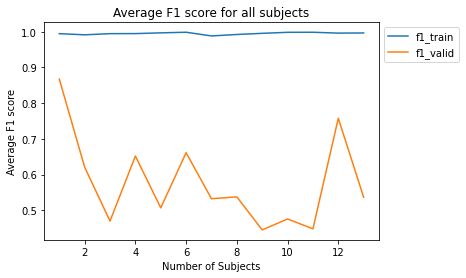

In [73]:
num_subj = len(uni_subject)
x_axis = [i+1 for i in range(num_subj)]


plt.plot(x_axis,f1_sub_train , label = 'f1_train')
plt.plot(x_axis,f1_sub_test, label = 'f1_valid')

plt.xlabel('Number of Subjects')
 
plt.ylabel('Average F1 score')
plt.title('Average F1 score for all subjects')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show()    

# Graph per subject

# Train Loss

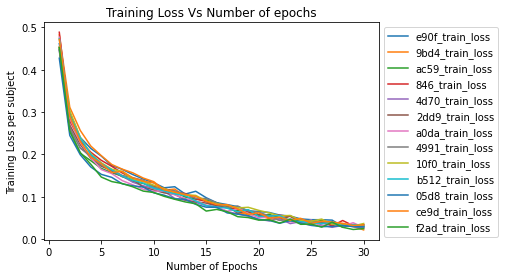

In [30]:
import matplotlib.pyplot as plt
num_epocs = 30
x_axis = [i+1 for i in range(num_epocs)]

for ind,i in enumerate(uni_subject):
    
    train_loss = str(i)+'_train_loss'
    locals()[train_loss] = sub_plot[ind]['loss']
    plt.plot(x_axis, locals()[train_loss], label = train_loss)

plt.xlabel('Number of Epochs')
 
plt.ylabel('Training Loss per subject')
plt.title('Training Loss Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show()    

# Training Accuracy

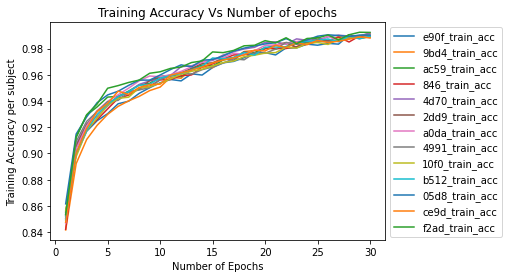

In [31]:
for ind,i in enumerate(uni_subject):
    train_acc = str(i)+'_train_acc'
    locals()[train_acc] = sub_plot[ind]['accuracy']
    plt.plot(x_axis, locals()[train_acc], label = train_acc)

plt.xlabel('Number of Epochs')
 
plt.ylabel('Training Accuracy per subject')
plt.title('Training Accuracy Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show() 

# Validation Loss

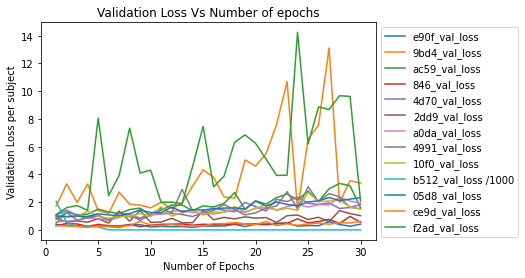

In [60]:
for ind,i in enumerate(uni_subject):
    if ind == 9:
        validation_loss = str(i)+'_val_loss'
        locals()[validation_loss] = sub_plot[ind]['val_loss'] 
        #print(locals()[validation_loss])

        plt.plot(x_axis, np.array(locals()[validation_loss])/ 1000, label = validation_loss + ' /1000')
    else:
        validation_loss = str(i)+'_val_loss'
        locals()[validation_loss] = sub_plot[ind]['val_loss'] 
 
        plt.plot(x_axis, locals()[validation_loss], label = validation_loss)

plt.xlabel('Number of Epochs')

plt.ylabel('Validation Loss per subject')
plt.title('Validation Loss Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show() 

# Validation accuracy

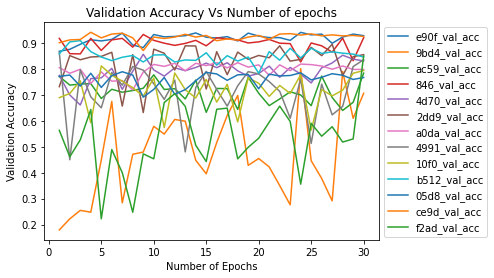

In [40]:
for ind,i in enumerate(uni_subject):
    val_acc = str(i)+'_val_acc'
    locals()[val_acc] = sub_plot[ind]['val_accuracy']
    plt.plot(x_axis, locals()[val_acc], label = val_acc)
    
    
plt.xlabel('Number of Epochs')

plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1))    
plt.show()

# Predictions

In [61]:
cls = np.array(range(5))
class_names = ['dribbling','shot','pass','layup','rebound']

print('\nTraining RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(train_gt, train_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(train_gt, train_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(train_gt, train_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(train_gt, train_preds, average='macro')))

print("\nTraining RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))


Training RESULTS: 

Avg. Accuracy: 0.990726689459095
Avg. Precision: 0.9969891932924965
Avg. Recall: 0.9936730113552974
Avg. F1: 0.9953218895353373

Training RESULTS (PER CLASS): 

Accuracy:
   dribbling: 99.62028282382776 %
   shot: 99.09660919066083 %
   pass: 97.39142597384432 %
   layup: 99.90437739056523 %
   rebound: 99.35064935064936 %

Precision:
   dribbling: 99.71305001620992 %
   shot: 99.74257836827901 %
   pass: 99.31536157466839 %
   layup: 99.96810546459707 %
   rebound: 99.75550122249389 %

Recall:
   dribbling: 99.90669836618473 %
   shot: 99.35070306038048 %
   pass: 98.04970780820953 %
   layup: 99.93623126793496 %
   rebound: 99.59316517493897 %

F1:
   dribbling: 99.80978026340773 %
   shot: 99.54625505024345 %
   pass: 98.6784765279008 %
   layup: 99.95216582513952 %
   rebound: 99.6742671009772 %


# Validation Accuracies

In [62]:
print('\nValidation RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(test_gt, test_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(test_gt, test_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(test_gt, test_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(test_gt, test_preds, average='macro')))

print("\nVALIDATION RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')

print("\nPrecision:")
for i, rslt in enumerate(precision_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    

print("\nRecall:")
for i, rslt in enumerate(recall_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    
print("\nF1:")
for i, rslt in enumerate(f1_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')


Validation RESULTS: 

Avg. Accuracy: 0.4600585662010417
Avg. Precision: 0.5821947733368569
Avg. Recall: 0.6283711669693781
Avg. F1: 0.5860648592670387

VALIDATION RESULTS (PER CLASS): 

Accuracy:
dribbling: 85.0
shot: 49.0
pass: 26.0
layup: 59.0
rebound: 11.0

Precision:
dribbling: 92.0
shot: 67.0
pass: 46.0
layup: 74.0
rebound: 13.0

Recall:
dribbling: 92.0
shot: 65.0
pass: 37.0
layup: 75.0
rebound: 45.0

F1:
dribbling: 92.0
shot: 66.0
pass: 41.0
layup: 74.0
rebound: 20.0


In [63]:
print("\nGENERALIZATION GAP ANALYSIS: ")
print("\nTrain-Val-Accuracy Difference: {0}".format(jaccard_score(train_gt, train_preds, average='macro') -
                                                  jaccard_score(test_gt, test_preds, average='macro')))
print("Train-Val-Precision Difference: {0}".format(precision_score(train_gt, train_preds, average='macro') -
                                                   precision_score(test_gt, test_preds, average='macro')))
print("Train-Val-Recall Difference: {0}".format(recall_score(train_gt, train_preds, average='macro') -
                                                recall_score(test_gt, test_preds, average='macro')))
print("Train-Val-F1 Difference: {0}".format(f1_score(train_gt, train_preds, average='macro') -
                                            f1_score(test_gt, test_preds, average='macro')))


GENERALIZATION GAP ANALYSIS: 

Train-Val-Accuracy Difference: 0.5306681232580533
Train-Val-Precision Difference: 0.4147944199556396
Train-Val-Recall Difference: 0.3653018443859193
Train-Val-F1 Difference: 0.4092570302682986


# Testing on Game data

In [64]:
print('game_data',game_data.shape)

label_game = game_data['basketball']
x_axis_game = sorted(label_game.unique())
y_axis_game = label_game.value_counts()

X_game = game_data.iloc[:,:-1]

def labelling(clean_data,data_y):
    clean_data[data_y == 'dribbling'] = 0
    clean_data[data_y == 'shot'] = 1
    clean_data[data_y == 'pass'] = 2
    clean_data[data_y == 'layup'] = 3
    clean_data[data_y == 'rebound'] = 4
    
    return data_y

y_game = labelling(game_data,game_data.iloc[:,-1]).astype(int)

data_labelled_game = np.concatenate((X_game, y_game[:,None]), axis=1)[:,2:] #669204, 6
print('data_labelled_game ',data_labelled_game.shape)

data_labelled_X = data_labelled_game[:,:-1]
data_labelled_Y = data_labelled_game[:,-1]

print(data_labelled_X.shape,data_labelled_Y.shape)
sw_length = 50
sw_overlap = 25

X_train_game, y_train_game = apply_sliding_window(data_labelled_X, data_labelled_Y, sliding_window_size=sw_length, 
                                        sampling_rate=50,sliding_window_overlap=sw_overlap)


X_train_game, y_train_game = X_train_game.astype(np.float32), y_train_game[:,0].astype(np.uint8)

print("\nShape of the X_train_game and y_train_game datasets after windowing: ")
print(X_train_game.shape, y_train_game.shape)

game_data (45111, 6)
data_labelled_game  (45111, 4)
(45111, 3) (45111,)

Shape of the X_train_game and y_train_game datasets after windowing: 
(1186, 50, 3) (1186,)


/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Loading the pretrained model

In [65]:
model = load_model('./Pre_Trained_models/LOSO')

pt = './Pre_Trained_models/LOSO/LOSO'
model.load_weights(pt)

In [66]:
loss_game,acc_game = model.evaluate(X_train_game,y_train_game)

print('___GAME___')
print(f'GAME_loss {round(loss_game,3)}, GAME_accuracy {round(acc_game,3)*100}')

38/38 [==============================] - 1s 17ms/step - loss: 76374.3047 - accuracy: 0.2833
___GAME___
GAME_loss 76374.305, GAME_accuracy 28.299999999999997


In [67]:
y_pred_game = np.argmax(model.predict(X_train_game), axis=-1)

#Training
acc_game = jaccard_score(y_train_game, y_pred_game, average='macro')
pre_game = precision_score(y_train_game, y_pred_game, average='macro', zero_division=0)
reca_game = recall_score(y_train_game, y_pred_game, average='macro', zero_division=0)
f1_game = f1_score(y_train_game, y_pred_game, average='macro', zero_division=0)

print("___GAME____")
print(f"accuracy {round(acc_game,3)*100} ,precision {round(pre_game,3)*100}, recall {round(reca_game,3)*100},f1_score {round(f1_game,3)*100} ")

___GAME____
accuracy 13.700000000000001 ,precision 25.4, recall 28.599999999999998,f1_score 23.3 


In [68]:
print('\nGame RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Precision: {0}".format(precision_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Recall: {0}".format(recall_score(y_train_game, y_pred_game, average='macro')))
print("Avg. F1: {0}".format(f1_score(y_train_game, y_pred_game, average='macro')))

print("\nGAME RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))


Game RESULTS: 

Avg. Accuracy: 0.13730614691905055
Avg. Precision: 0.25393920881855553
Avg. Recall: 0.2858244514542953
Avg. F1: 0.23267202923912195

GAME RESULTS (PER CLASS): 

Accuracy:
dribbling: 28.000000000000004
shot: 9.0
pass: 5.0
layup: 18.0
rebound: 8.0

Precision:
dribbling: 50.0
shot: 11.0
pass: 28.000000000000004
layup: 22.0
rebound: 16.0

Recall:
dribbling: 38.0
shot: 31.0
pass: 6.0
layup: 53.0
rebound: 14.000000000000002

F1:
dribbling: 43.0
shot: 17.0
pass: 10.0
layup: 31.0
rebound: 15.0


# END